<a href="https://colab.research.google.com/github/Eserhimas/Basics/blob/main/Time_Series_Forecasting_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing, svm

import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [ ]:
# https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/data?select=sales_train.csv

data = pd.read_csv('/content/sales_train.csv')

data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

ts = data.groupby("date")["item_cnt_day"].sum().rename("sales")

ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

In [ ]:
ts.tail()

date
2015-10-27    1551.0
2015-10-28    3593.0
2015-10-29    1589.0
2015-10-30    2274.0
2015-10-31    3104.0
Name: sales, dtype: float64

In [ ]:
ts.describe()

count     1034.000000
mean      3528.245648
std       1584.687467
min       1274.000000
25%       2472.250000
50%       3145.000000
75%       4257.000000
max      13343.000000
Name: sales, dtype: float64

<Axes: xlabel='date'>

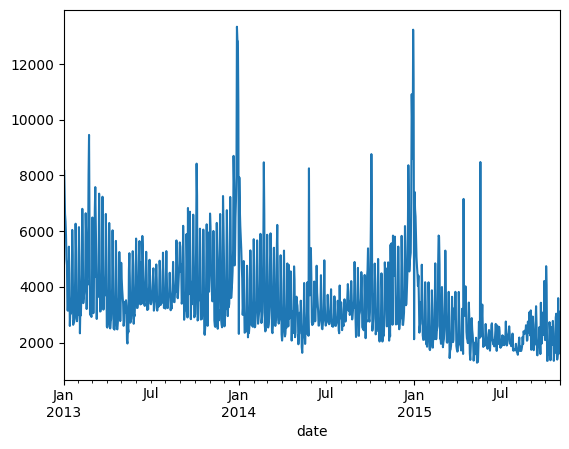

In [ ]:
ts.plot()

In [ ]:
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(15,5)):

            rolling_mean = ts.rolling(window=window).mean()
            rolling_std = ts.rolling(window=window).std()

            plt.figure(figsize=figsize)
            plt.title(ts.name)
            plt.plot(ts[window:], label='Actual values', color='black')
            if plot_ma:
              plt.plot(rolling_mean, 'g', label='MA'+str(window), color='red')
            if plot_intervals:
              lower_bound = rolling_mean - (1.96 * rolling_std)
              upper_bound = rolling_mean + (1.96 * rolling_std)
            plt.fill_between(x=ts.index, y1=lower_bound, y2=upper_bound,
                             color='lightskyblue', alpha=0.4)
            plt.legend(loc='best')
            plt.grid(True)
            plt.show()

<ipython-input-24-0ae5f785cbf6>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window), color='red')


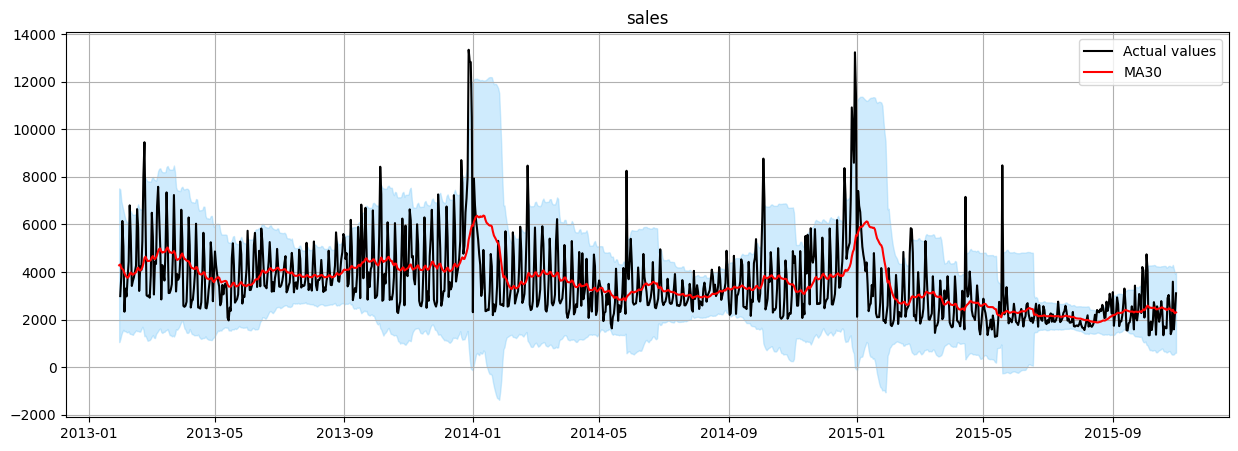

In [ ]:
plot_ts(ts, window=30)

<ipython-input-24-0ae5f785cbf6>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='MA'+str(window), color='red')


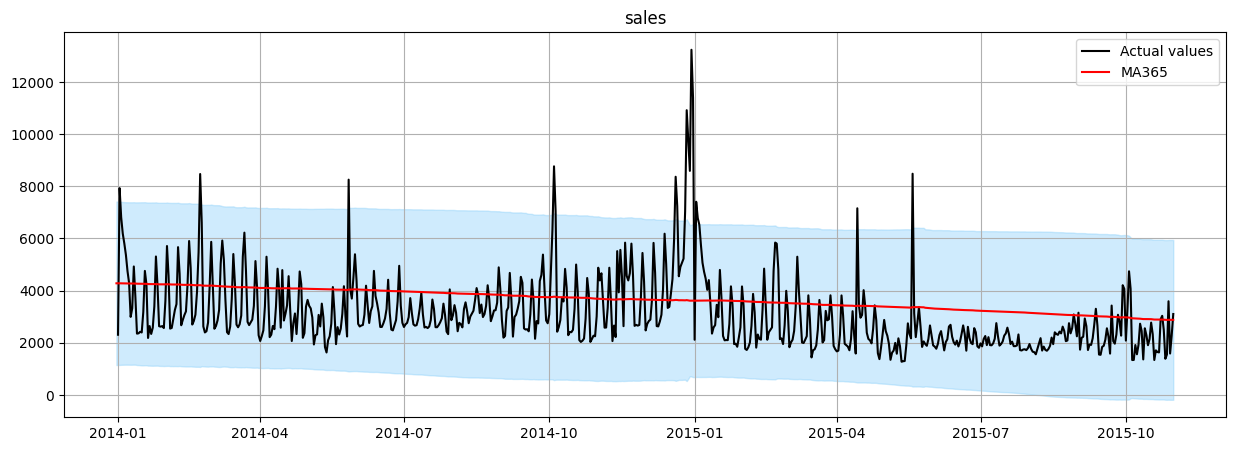

In [ ]:
plot_ts(ts, window=365)

<Axes: >

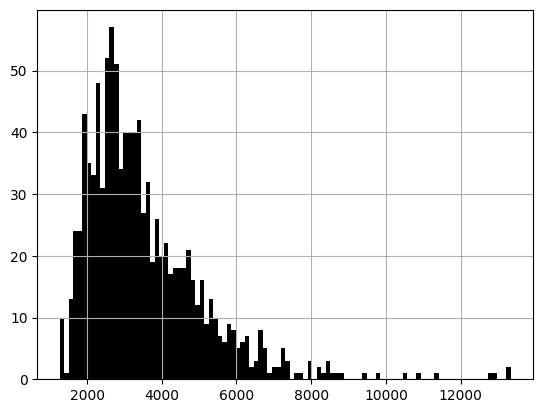

In [ ]:
ts.hist(color='black', bins=100)

<Axes: >

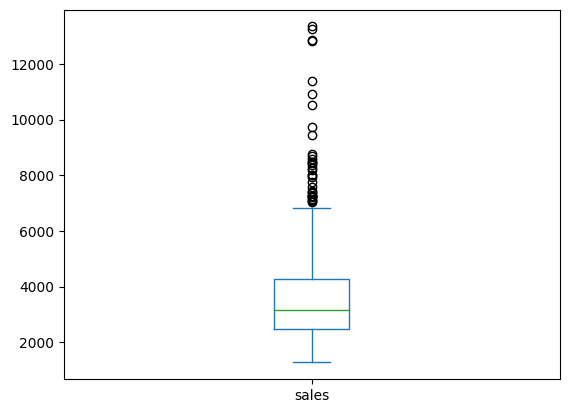

In [ ]:
ts.plot.box()

In [ ]:
def find_outliers(ts, perc=0.01, figsize=(15,5)):
  scaler = preprocessing.StandardScaler()
  ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
  model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
  model.fit(ts_scaled)

  data_outliers = ts.to_frame(name='ts')
  data_outliers["index"] = range(len(ts))
  data_outliers["outlier"] = model.predict(ts_scaled)
  data_outliers["outlier"] = data_outliers["outlier"].apply(
      lambda x: 1 if x==-1 else 0)

  fig, ax = plt.subplots(figsize=figsize)
  ax.set(title="Outliers detection: found" + str(sum(data_outliers["outlier"]==1)))
  ax.plot(data_outliers["index"], data_outliers["ts"], color="black")
  ax.scatter(x=data_outliers[data_outliers["outlier"]==1]["index"],
             y=data_outliers[data_outliers["outlier"]==1]["ts"],
             color='red')

  ax.grid(True)
  plt.show()
  return data_outliers

In [ ]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
  ts_clean = ts.copy()
  ts_clean.loc[outliers_idx] = np.nan
  ts_clean = ts_clean.interpolate(method="linear")
  ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
               title="Remove Outliers", label="original", legend=True)

  ts_clean.plot(ax=ax, grid=True, color="black", label="interpolated", legend=True)

  plt.show()
  return ts_clean

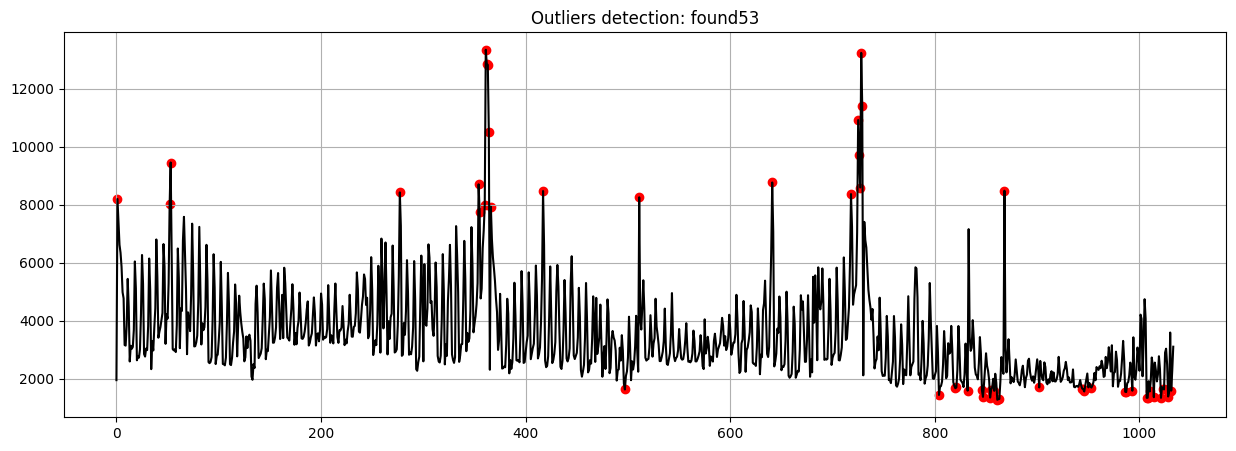

In [ ]:
dtf_outliers = find_outliers(ts, perc=0.05)

In [ ]:
out_idx_pos = dtf_outliers[dtf_outliers["outlier"]==1].index

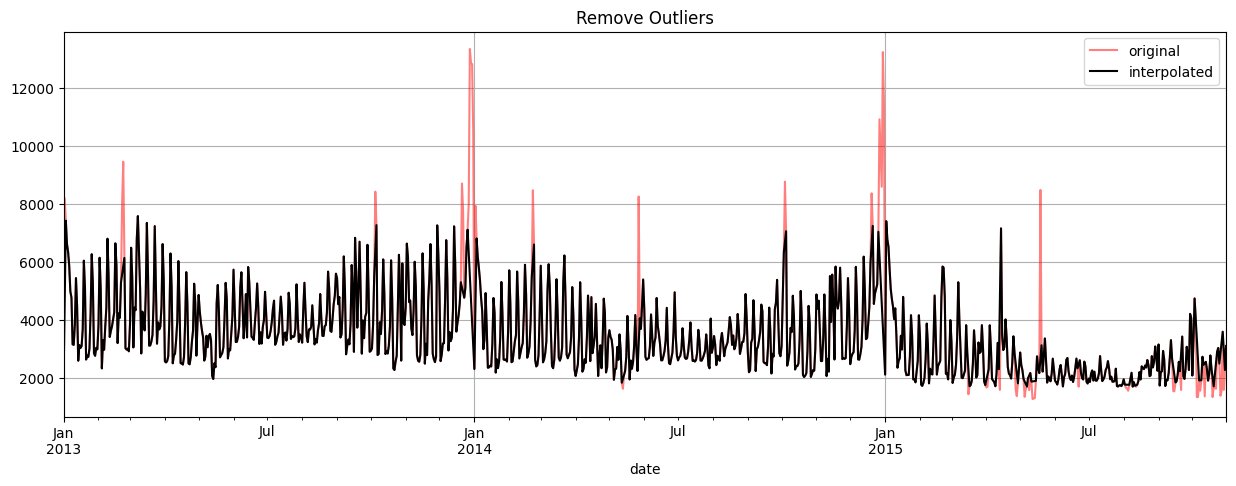

In [ ]:
# excluding outliers
ts_clean = remove_outliers(ts, outliers_idx=out_idx_pos)

In [ ]:
def test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30, figsize=
                              (15,10)):
    with plt.style.context(style='bmh'):
        ## set figure
        fig = plt.figure(figsize=figsize)
        ts_ax = plt.subplot2grid(shape=(2,2), loc=(0,0), colspan=2)
        pacf_ax = plt.subplot2grid(shape=(2,2), loc=(1,0))
        acf_ax = plt.subplot2grid(shape=(2,2), loc=(1,1))

        ## plot ts with mean/std of a sample from the first x%
        dtf_ts = ts.to_frame(name="ts")
        sample_size = int(len(ts)*sample)
        dtf_ts["mean"] = dtf_ts["ts"].head(sample_size).mean()
        dtf_ts["lower"] = dtf_ts["ts"].head(sample_size).mean()
                          + dtf_ts["ts"].head(sample_size).std()
        dtf_ts["upper"] = dtf_ts["ts"].head(sample_size).mean()
                          - dtf_ts["ts"].head(sample_size).std()
        dtf_ts["ts"].plot(ax=ts_ax, color="black", legend=False)
        dtf_ts["mean"].plot(ax=ts_ax, legend=False, color="red",
                            linestyle="--", linewidth=0.7)
        ts_ax.fill_between(x=dtf_ts.index, y1=dtf_ts['lower'],
                y2=dtf_ts['upper'], color='lightskyblue', alpha=0.4)
        dtf_ts["mean"].head(sample_size).plot(ax=ts_ax,
                legend=False, color="red", linewidth=0.9)
        ts_ax.fill_between(x=dtf_ts.head(sample_size).index,
                           y1=dtf_ts['lower'].head(sample_size),
                           y2=dtf_ts['upper'].head(sample_size),
                           color='lightskyblue')

        ## test stationarity (Augmented Dickey-Fuller)
        adfuller_test = sm.tsa.stattools.adfuller(ts, maxlag=maxlag,
                                                  autolag="AIC")
        adf, p, critical_value = adfuller_test[0], adfuller_test[1],
                                 adfuller_test[4]["5%"]
        p = round(p, 3)
        conclusion = "Stationary" if p < 0.05 else "Non-Stationary"
        ts_ax.set_title('Dickey-Fuller Test 95%: '+conclusion+
                        '(p value: '+str(p)+')')

        ## pacf (for AR) e acf (for MA)
        smt.graphics.plot_pacf(ts, lags=maxlag, ax=pacf_ax,
                 title="Partial Autocorrelation (for AR component)")
        smt.graphics.plot_acf(ts, lags=maxlag, ax=acf_ax,
                 title="Autocorrelation (for MA component)")
        plt.tight_layout()

In [ ]:
test_stationarity_acf_pacf(ts, sample=0.20, maxlag=30)